#### Библиотеки, девайс и функции

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from torch import nn
from tqdm.auto import tqdm
from torchvision import models
from torchinfo import summary
from torchvision.datasets import Food101

In [3]:
from torch.cuda import is_available
device = "cuda" if is_available() else "cpu"
device

'cuda'

In [4]:
def make_data(train_data, test_data, batch_size, num_workers):

    #train_data = torchvision.datasets.ImageFolder(root=train_dir_path, transform=trans)
    #test_data = torchvision.datasets.ImageFolder(root=test_dir_path, transform=trans)

    train_dataloader = DataLoader(dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers)
    test_dataloader = DataLoader(dataset=test_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers)
    classes_names = train_data.classes

    return train_dataloader, test_dataloader, classes_names

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [6]:
def plots(train_loss_values, train_acc_values, test_loss_values, test_acc_values, train_epoch_count, test_epoch_count):
    plt.subplot(2, 1, 1)
    plt.plot(train_epoch_count, train_acc_values, c='g', label='Train Acc')
    plt.plot(train_epoch_count, test_acc_values, c='r', label='Test ACC')
    plt.title('Acc')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(train_epoch_count, train_loss_values, c='blue', label="Train Loss")
    plt.plot(train_epoch_count, test_loss_values, c='orange', label="Test Loss")
    plt.title('Loss')
    plt.legend();

In [7]:
def save_model(model, MODEL_PATH, model_name):
    SAVE_PATH = MODEL_PATH / model_name
    torch.save(obj = model.state_dict(),
               f = SAVE_PATH)
    print(f"Saved to: {SAVE_PATH}")

In [8]:
def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, epochs, device):
    train_epoch_count = []
    train_loss_values = []
    train_acc_values = []
    test_epoch_count = []
    test_loss_values = []
    test_acc_values = []
    #epochs = 10
    for epoch in tqdm(range(epochs)):
        # Train Block
        ls_loss = 0
        ls_acc = 0

        model.train()

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            #y = y.type(torch.long)

            logits = model(X).squeeze()
            preds = torch.argmax(torch.softmax(logits, dim=1),dim=1)
            #print(X.shape, y.shape, logits.shape)
            loss = loss_fn(logits, y)
            acc = accuracy_fn(y_true = y, y_pred = preds)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ls_loss += loss.item()
            ls_acc += acc
            if batch % 400 == 0:
                print(f"Epoch: {epoch+1} | Batch: {batch}...")
        mean_loss = ls_loss / len(train_dataloader)
        mean_acc = ls_acc / len(train_dataloader)
        train_loss_values.append(loss.item())
        train_acc_values.append(acc)
        train_epoch_count.append(epoch+1)
        print(f"Epoch: {epoch+1} | Loss: {mean_loss:.4f} | Acc: {mean_acc:.2f}%")


        # Test Block
        ls_loss, ls_acc = 0, 0

        model.eval()

        for batch, (X, y) in enumerate(test_dataloader):
            with torch.inference_mode():
                X, y = X.to(device), y.to(device)
                #y = y.type(torch.long)
                mean_loss, mean_acc = 0, 0
                logits = model(X).squeeze()
                preds = torch.argmax(torch.softmax(logits, dim=1),dim=1)
                loss = loss_fn(logits, y)
                acc = accuracy_fn(y_true = y,y_pred = preds)
                ls_loss += loss.item()
                ls_acc += acc
                if batch % 300 == 0:
                    print(f"TEST :    Epoch: {epoch+1} | Batch: {batch}...")
        mean_loss = ls_loss / len(test_dataloader)
        mean_acc = ls_acc / len(test_dataloader)
        test_loss_values.append(loss.item())
        test_acc_values.append(acc)
        test_epoch_count.append(epoch+1)
        print(f"TEST :    Epoch: {epoch+1} | Loss: {mean_loss:.4f} | Acc: {mean_acc:.2f}%\n\n")
    return train_loss_values, train_acc_values, test_loss_values, test_acc_values, train_epoch_count, test_epoch_count

# ViT_b_16

In [ ]:
# получение весов модели и трансформации модели
ViT_b_16_weights = models.ViT_B_16_Weights.DEFAULT
auto_transform = ViT_b_16_weights.transforms()
# получение датасета с транформацией
train_data = Food101(root="data/train",
                     split="train",
                     download=True,
                     transform=                  auto_transform)
test_data = Food101(root="data/test",
                     split="test",
                     download=True,
                     transform=                  auto_transform)

cpu_c = os.cpu_count()
BATCH_SIZE = 32
# получение даталоадеров и списка классов
train_dataloader, test_dataloader, classes_names = make_data(train_data, test_data, batch_size=BATCH_SIZE, num_workers=cpu_c)
train_dataloader, test_dataloader, classes_names[:10], auto_transform

100%|██████████| 5.00G/5.00G [03:19<00:00, 25.1MB/s]
100%|██████████| 5.00G/5.00G [03:59<00:00, 20.9MB/s]


(<torch.utils.data.dataloader.DataLoader at 0x7d42062e0650>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [ ]:
ViT_b_16 = models.vit_b_16(weights=ViT_b_16_weights).to(device)
auto_transform = ViT_b_16.transforms()

In [ ]:
ViT_b_16.heads.head = nn.Linear(in_features=768, out_features=101, bias=True).to(device)

In [ ]:
summary(model=ViT_b_16,input_size=(32, 3, 224, 224),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 101]            768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [ ]:
for params in ViT_b_16.parameters():
        params.requires_grad=False

for params in ViT_b_16.heads.parameters():
        params.requires_grad=True

In [ ]:
summary(model=ViT_b_16,input_size=(32, 3, 224, 224),col_names=['input_size', 'output_size',"num_params", 'trainable'],col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 101]            768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0...
Epoch: 1 | Batch: 400...
Epoch: 1 | Batch: 800...
Epoch: 1 | Batch: 1200...
Epoch: 1 | Batch: 1600...
Epoch: 1 | Batch: 2000...
Epoch: 1 | Loss: 0.8640 | Acc: 77.79%
TEST :    Epoch: 1 | Batch: 0...
TEST :    Epoch: 1 | Batch: 300...
TEST :    Epoch: 1 | Batch: 600...
TEST :    Epoch: 1 | Loss: 0.8018 | Acc: 78.61%




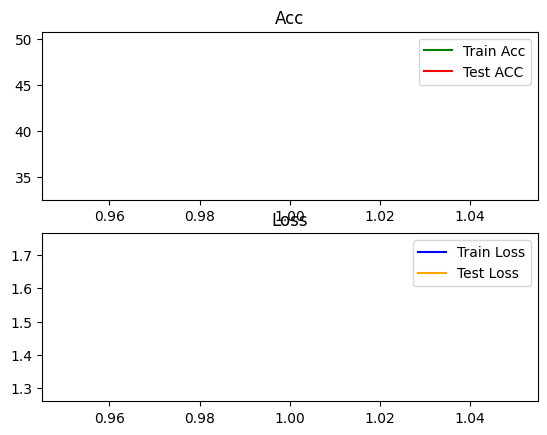

In [ ]:
optimizer = torch.optim.SGD(ViT_b_16.parameters(),
                              lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train_loss_values_ViT_b_16, train_acc_values_ViT_b_16, test_loss_values_ViT_b_16, test_acc_values_ViT_b_16, train_epoch_count_ViT_b_16, test_epoch_count_ViT_b_16 = train_model(
    model=ViT_b_16, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
            optimizer=optimizer, loss_fn=loss_fn ,accuracy_fn=accuracy_fn, epochs=1, device=device)

plots(train_loss_values_ViT_b_16, train_acc_values_ViT_b_16, test_loss_values_ViT_b_16, test_acc_values_ViT_b_16, train_epoch_count_ViT_b_16, test_epoch_count_ViT_b_16)

In [ ]:
MODEL_PATH_vIT_AFTER_5EPOCHS = Path("/models")
MODEL_NAME_vIT_AFTER_5EPOCHS = "second_model_TiV_16_b.pth"
MODEL_PATH_vIT_AFTER_5EPOCHS / MODEL_NAME_vIT_AFTER_5EPOCHS
save_model(ViT_b_16, MODEL_PATH_vIT_AFTER_5EPOCHS, MODEL_NAME_vIT_AFTER_5EPOCHS)

RuntimeError: Parent directory /content/transfer_learnin_models does not exist.